# Introduction

* Hello, our names are Vincent and J. Vincent Shorter

## Project Objective 
* This project runs through the entire Data Science Pipeline and culminates with classification modelling techniques based upon Natural Langauge Processing outcomes.
* Pproject constructs a ML model to predict a github repository coding language based on just the project README file. 

## Executive Summary


* Analysis of the data showed that Python was by far the most popular language
* 


# Import Section

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import unicodedata
import re
import wrangle 
from importlib import reload
import scipy.stats as stats
import model
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
plt.rc('figure', figsize=(13, 7))
plt.style.use('dark_background')

# Wrangle (Acquire and Prep)
* By far most difficult and laborious portion of project. 
* Had to contend with empty, non-English, and often sparse READMEs

### Nulls/Missing Values
* Simple drop of null values as they most often indicated an empty README
---
### Feature Engineering 
* Engineered `word_count` in order to facilitate analysis around column length and unique word density
* Engineered `language_bigrams` in order to capture most used word duos
---   
### Flattening
* Had to make decisions in order to remove optionality from language column due to sample size 
- Went from around 17 languages down to 7 by creating an `other` category for the less popular langauges
* Decisons here driven mostly by desire to have enough observations for effective analysis 
---


## Exploration Questions 
* Includes visualizations and statistical tests
* Primarily focused on analyzing frequency differences between language groups

In [2]:
#calling prepare/acquire functions from module to acquire and split data subsets
df = wrangle.get_search_csv()
df = wrangle.prep_text(df)
train, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_scale(df)

## Spotlight - Common Words 
* **Question:** What are the most common words in READMEs?
* **Answer:** (Word with # of appearances)
    - Team: 341
    - Game: 293
    - Player: 281 
    - Data: 263
    - Season: 144


In [3]:
def get_words_and_freq():
    # Isolate words by type/frequency
    java_words = (' '.join(df.lemmatized[df.language == 'javascript'])).split()
    python_words = (' '.join(df.lemmatized[df.language == 'python'])).split()
    html_words = (' '.join(df.lemmatized[df.language == 'html'])).split()
    other_words = (' '.join(df.lemmatized[df.language == 'other'])).split()
    all_words = (' '.join(df.lemmatized)).split()

    java_freq = pd.Series(java_words).value_counts()
    python_freq = pd.Series(python_words).value_counts()
    html_freq = pd.Series(html_words).value_counts()
    other_freq = pd.Series(other_words).value_counts()
    all_freq = pd.Series(all_words).value_counts()

    # concatonate words for count
    word_counts = (pd.concat([all_freq, java_freq, python_freq, html_freq, other_freq], axis=1, sort=True)
                .set_axis(['all','javascript', 'python', 'html','other'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
    return java_words, python_words, html_words, other_words, all_words, java_freq, python_freq, html_freq, other_freq, all_freq, word_counts

In [4]:
java_words, python_words, html_words, other_words, all_words, java_freq, python_freq, html_freq, other_freq, all_freq, word_counts = get_words_and_freq()

In [5]:
#created class in order to facilitate bigram and trigram creation
class code_language:
  def __init__(self, words, label:str):
    self.words = words
    self.label = label
    self.unique_to_language = set()

  def whole_words(self): 
    return pd.Series(self.words.split())

  def word_counts(self):
    return pd.Series(self.words.split()).value_counts()

  def unique_words(self):
    return set(pd.Series(self.whole_words().unique()))

  def bigrams(self):
    return pd.Series(list(nltk.bigrams(self.words.split())))

  def trigrams(self):
    return pd.Series(list(nltk.ngrams(self.words.split(), 3)))

  def readme_count(self):
    return df[df.language == self.label].word_count.count()

In [6]:
all_ = code_language(words=' '.join(df.lemmatized), label='all languages')

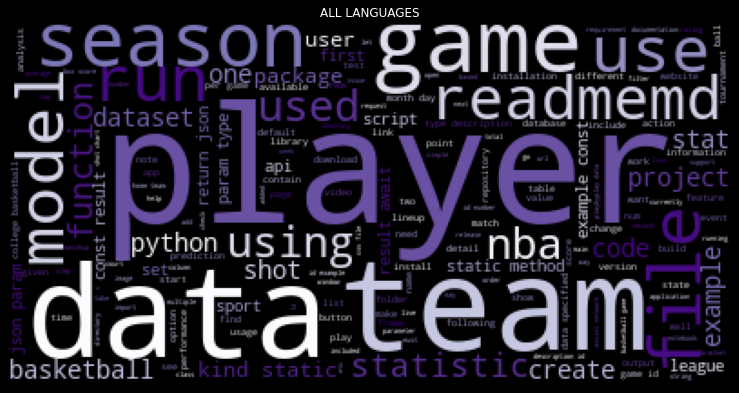

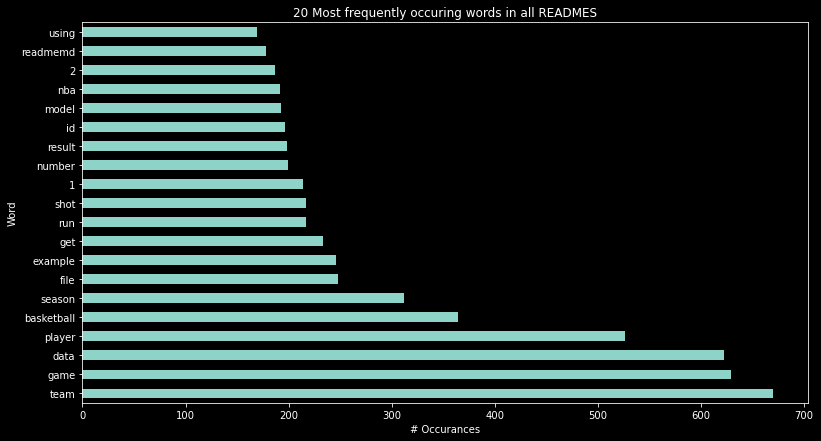

In [7]:
img = WordCloud(background_color='black',colormap='Purples').generate(' '.join(all_words))
plt.imshow(img)
plt.axis('off')
plt.title(all_.label.upper())
plt.show()
all_freq.head(20).plot.barh()
plt.title('20 Most frequently occuring words in all READMES')
plt.ylabel('Word')
plt.xlabel('# Occurances')
plt.show()

#### Takeaways:
- The most popular words are team, game, player data, and season.

### Spotlight - README Length
* **Question:** Does the length of the README vary by programming language?

* **Answer:** Yes, of the languages that were found, readme length tends to vary based on the language in the readme, with HTML on average having the smallest README Lengths.
#### Statistical Hypothesis
>* ${H_0}$: There is no difference in README length between languages. 
>* ${H_a}$: There is a difference in README length between languages.  
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

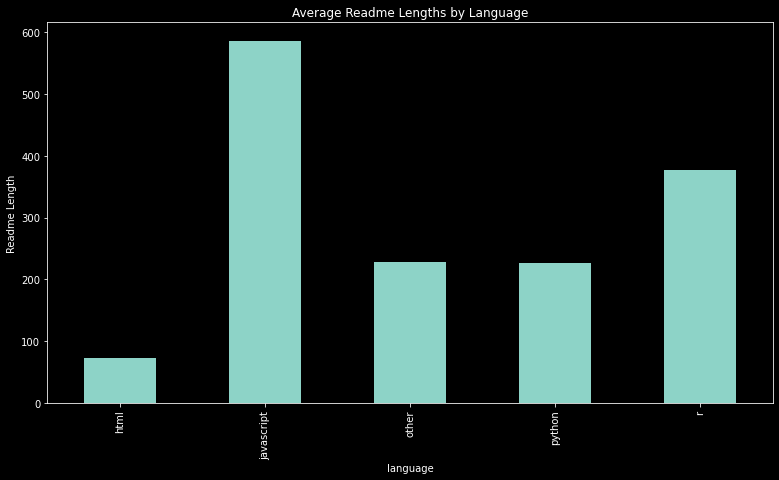

In [8]:
# Bar plot function for Vis
def bar_plot(df, target, readme_length):
    '''
    This function is to create a bar plot. Take in dataframe, a target and a feature
    '''
    df.groupby(target)[readme_length].mean().plot.bar()
    plt.title('Average Readme Lengths by Language')
    plt.ylabel('Readme Length')
    plt.show()
    return
bar_plot(train, 'language', 'word_count')


In [9]:
def stat_test(train, readme_length):
    '''
    Perform 1 sample t-test comparing mean length of original
    README file per language to the overall average length (all languages)
    set the significance level to 0.05
    '''
    alpha = 0.05
    overall_mean_length_readme = df['word_count'].mean()
    for l in train.language.unique():
        sample = train[train.language == l]
        t,p = stats.ttest_1samp(sample[readme_length], overall_mean_length_readme)
        print(l, round(t,5), p<alpha)
# Perform 1 sample t-test comparing length of lemmatized README file per language to the overall average length (all languages)
stat_test(train, 'word_count')

other -0.67521 False
html -7.05631 True
python -1.35518 False
javascript 0.76097 False
r 0.8416 False


### Spotlight - Unique Words
* **Question:** Do different programming languages use a different number of unique words?
 
* **Answer:**  Yes, each programming language has a different number of Unique words. \
Python: 1733 \
JavaScript: 219 \
HTML: 83 \
Other: 607

In [10]:
def unique_counts(word_counts):
    '''
    This function takes our word_counts dataframe and finds the number of uniques to each language and returns them as their own dataframes. 
    '''
    # Adding a column for each language with 1 or 0 (str) to represent if it is unique to that language
    word_counts['python_unique'] = np.where(word_counts['all'] == word_counts['python'], '1', '0')
    word_counts['js_unique'] = np.where(word_counts['all'] == word_counts['javascript'], '1', '0')
    word_counts['html_unique'] = np.where(word_counts['all'] == word_counts['html'], '1', '0')
    word_counts['other_unique'] = np.where(word_counts['all'] == word_counts['other'], '1', '0')

    # Getting separate df's for these unique words
    python_unique = word_counts[['python']][word_counts.python_unique == '1']
    js_unique = word_counts[['javascript']][word_counts.js_unique == '1']
    html_unique = word_counts[['html']][word_counts.html_unique == '1']
    other_unique = word_counts[['other']][word_counts.other_unique == '1']

    # returning the three dataframes
    return python_unique, js_unique, html_unique, other_unique

In [11]:
python_unique, js_unique, html_unique, other_unique = unique_counts(word_counts)

In [12]:
def get_readme_text_for_lang():
    # Concatenate readme content together for each language
    python_ws = ' '.join(train[train.language == 'python'].lemmatized)
    java_ws = ' '.join(train[train.language == 'javascript'].lemmatized)
    html_ws = ' '.join(train[train.language == 'html'].lemmatized)
    other_ws = ' '.join(train[train.language == 'other'].lemmatized)
    r_ws = ' '.join(train[train.language == 'r'].lemmatized)
    all_ws = ' '.join(train.lemmatized)
    return python_ws, java_ws, html_ws, other_ws, r_ws, all_ws
python_ws, java_ws, html_ws, other_ws, r_ws, all_ws = get_readme_text_for_lang()

In [13]:
def most_common_word_plot():
    plt.subplot(221)
    plt.xlabel('Words', fontsize = 10)
    plt.ylabel('Frequency', fontsize = 10)
    plt.title(f"Top 20 Most Common Words for Python", fontsize = 20)
    sns.barplot(x=python_freq.head(20).index,y=python_freq.head(20).values, palette ='Purples_r')
    plt.xticks(rotation=45)
  
    plt.subplot(222)
    plt.xlabel('Words', fontsize = 10)
    plt.ylabel('Frequency', fontsize = 10)
    plt.title(f"Top 20 Most Common Words for Javascript", fontsize = 20)
    sns.barplot(x=java_freq.head(20).index,y=java_freq.head(20).values, palette ='Purples_r')
    plt.xticks(rotation=45)
  
    plt.subplot(223)
    plt.xlabel('Words', fontsize = 10)
    plt.ylabel('Frequency', fontsize = 10)
    plt.title(f"Top 20 Most Common Words for HTML", fontsize = 20)
    sns.barplot(x=html_freq.head(20).index,y=html_freq.head(20).values, palette ='Purples_r')
    plt.xticks(rotation=45)

    plt.subplot(224)
    plt.xlabel('Words', fontsize = 10)
    plt.ylabel('Frequency', fontsize = 10)
    plt.title(f"Top 20 Most Common Words for Other", fontsize = 20)
    sns.barplot(x=other_freq.head(20).index,y=other_freq.head(20).values, palette ='Purples_r')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return

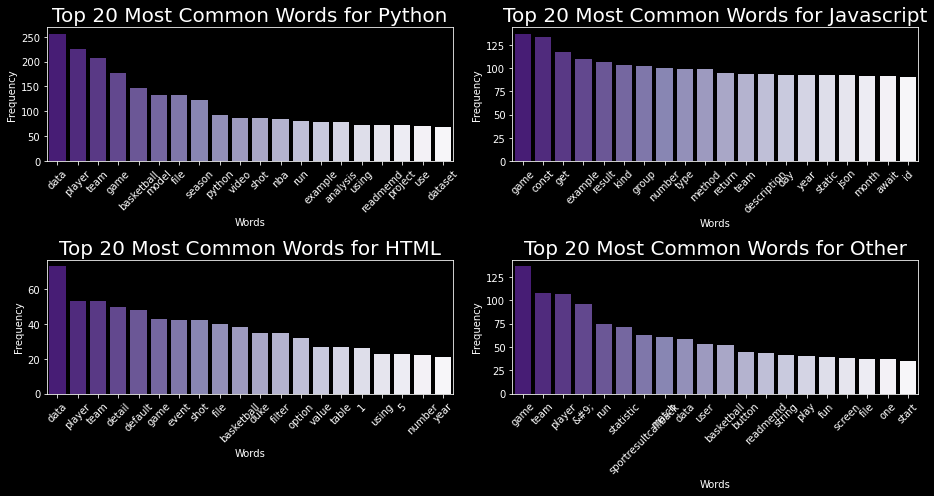

In [14]:
most_common_word_plot()

In [15]:
len(python_unique), len(js_unique), len(html_unique),len(other_unique)

(2701, 677, 844, 1074)

### Spotlight - Language ID by Word
* **Question:** Are there any bigrams that uniquely identify a programming language?
 
* **Answer:** Yes, there are bigrams that uniquely identify a programming language.

In [16]:
def get_bigrams():
    python_bigrams = pd.Series(nltk.ngrams(python_ws.split(),2)).value_counts()
    js_bigrams = pd.Series(nltk.ngrams(java_ws.split(),2)).value_counts()
    html_bigrams = pd.Series(nltk.ngrams(html_ws.split(),2)).value_counts()
    other_bigrams = pd.Series(nltk.ngrams(other_ws.split(),2)).value_counts()
    r_bigrams = pd.Series(nltk.ngrams(r_ws.split(), 2)).value_counts()
    return python_bigrams, js_bigrams, html_bigrams, other_bigrams, r_bigrams
python_bigrams, js_bigrams, html_bigrams, other_bigrams, r_bigrams = get_bigrams()

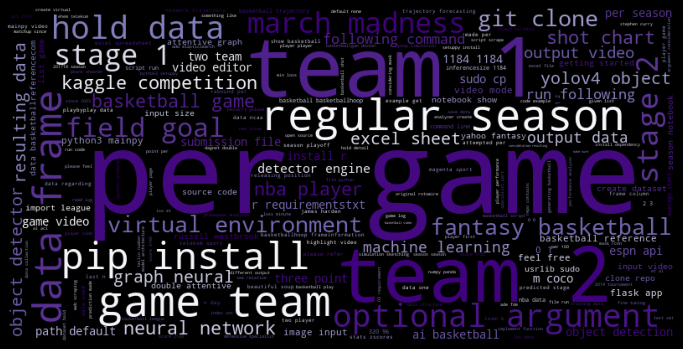

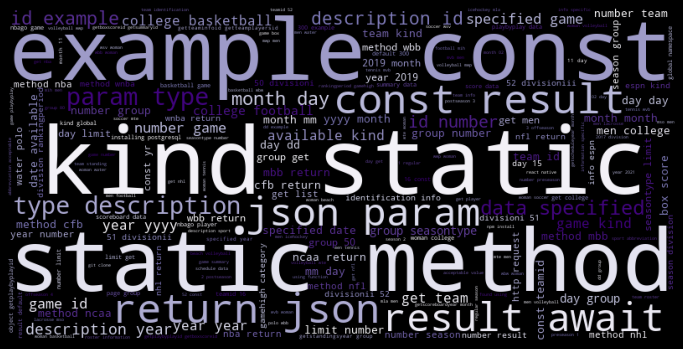

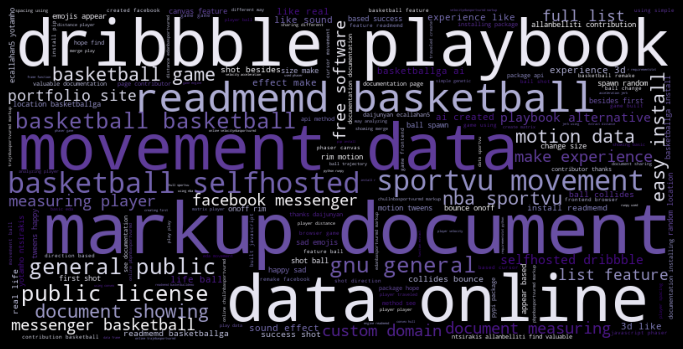

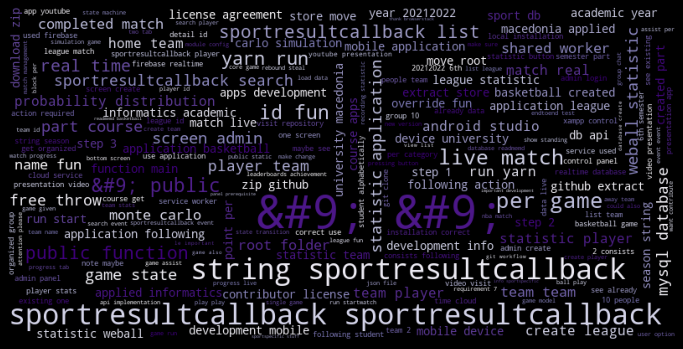

In [17]:
# iterates over the languages and creates a word cloud for each one 
bg_list = [python_bigrams, js_bigrams, html_bigrams, other_bigrams]
for bg in bg_list:
    data = {k[0] + ' ' + k[1]: v for k, v in bg.to_dict().items()}
    # Using wordcloud to visualize most common words
    img = WordCloud(background_color='black',colormap='Purples', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Exploration Summary
* Most common words in all READMES are Team, Game, Player, Data, and Season.
* Yes, of the languages that were found, readme length tends to vary based on the language in the readme, with HTML on average having the smallest README Lengths.
* Yes, each programming language has a different number of Unique words.
* Yes, there are bigrams that uniquely identify a programming language.

# Modeling
- Things did not go as plan. Initially had massive perfomanc drops moving in Validation
- Use of custom class proved to be more of a hindrance than help
- Had to abandon gridsearch idea, and focus on feature creation
- Logistic Regression never provided much performance gain above baseline
- DTC models consistenly peformed well, and, along with RF, we started lowering depth to control for overfitting 
- We did 5 rounds of mass cohort testing before settling on specific hyperparameters
- Final Models had 37% performamce gain above baseline when scoring with Accuracy as focus
--- 


In [18]:
def bigram_placement(language):
    """ 
    Purpose:
        to create bigrams for each langauge
    ---
    Parameters:
        language: input language
    ---
    Returns:
        a list of bigrams appropriately joined for further use
    """
    # this initilizes the class objects. 
    html = model.code_language(words=' '.join(df[df.language == 'html'].lemmatized), label='html')
    javascript = model.code_language(words=' '.join(df[df.language == 'javascript'].lemmatized), label='javascript')
    r_ = model.code_language(words=' '.join(df[df.language == 'r'].lemmatized), label='r')
    other_ = model.code_language(words=' '.join(df[df.language == 'other'].lemmatized), label='other')
    python_ = model.code_language(words=' '.join(df[df.language == 'python'].lemmatized), label='python')
    all_ = model.code_language(words=' '.join(df.lemmatized), label='all languages')

    #creates bigrams for seperate languages
    if language == 'html':
        language = html.bigrams()
    elif language == 'javascript':
        language = javascript.bigrams()
    elif language == 'r':
        language = r_.bigrams()
    elif language == 'python':
        language = python_.bigrams()
    else:
        language = other_.bigrams()
    return ', '.join(str(e) for e in language.str.join(sep=' ').to_list())

In [19]:
# applies bigram function to new column
df.language_bigrams = df.language_bigrams.apply(bigram_placement)

#grabs data subsets after vectorization and splitting
train, X_train, y_train, X_validate, y_validate, X_test, y_test = model.vectorize_split(df)

#places subsets in data for import into final function
subsets = [train, X_train, y_train, X_validate, y_validate, X_test, y_test]

#final function to grab model scores
model.get_test_score(df, subsets)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.402299,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.759300,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 5


## Features for Modeling
* Grouped by simple features: `word_count`, `lemmatized`, `language_bigrams`

* `word_count` - engineered
    * Chosen to highlight the business oriented concerns around employement  


* `lemmatized`
    * Highlights family and environment characteristics  
    


* `language_bigrams` - engineered
    * Highlights word bigrams popular within each language  
---

## Top Models


* Exposed Top 5 models from train section to the Validate data
* Models had to perform underneath 93% on train set to control for possible overfitting
* DTC models maintained highest performance profile througout all testing cohorts
---
* Model performace on Train subset:

Model	| Accuracy(Score)   |Type                       |Features Used                           |Parameters             |
|---    | ---               |---                        |   -----                                |---                    |
|RF_6   |	0.91950         |Random Forest              |word_count, lemmatized, language_bigrams|Depth: 7, Leaves: 3
|RF_0   |	0.91950         |Random Forest              |word_count, lemmatized, language_bigrams|Depth: 5, Leaves: 3
|DTC_1  |   0.91950         |Decision Tree Classifier   |word_count, lemmatized, language_bigrams|Depth: 6
|DTC_0  |	0.89066	        |Decision Tree Classifier	|word_count, lemmatized, language_bigrams|Depth: 5
|KNN_4  |	0.56322	        |K-Nearest Neighbors	    |word_count, lemmatized, language_bigrams|K-Neighbors: 4

---
## Test
* Top Model Performance on Test set:  

|    | Model    |   Accuracy(Score) | Type                     | Features Used                                    | Parameters   |
|---:|:---------|------------------:|:-------------------------|:-------------------------------------------------|:-------------|
|  0 | Baseline |          0.402299 | Basic Baseline           | Baseline Prediction                              | n/a          |
|  1 | DTC_0    |          0.7778   | Decision Tree Classifier | ['word_count', 'lemmatized', 'language_bigrams'] | Depth: 5     |

---

# Conclusion
## Summary of Key Findings
* Most common words in all READMES are Team, Game, Player, Data, and Season.
* Yes, of the languages that were found, readme length tends to vary based on the language in the readme, with HTML on average having the smallest README Lengths.
* Yes, each programming language has a different number of Unique words.
* Yes, there are bigrams that uniquely identify a programming language.
* DTC and RF models consistenly performed well
* Final Models had 37% performamce gain above baseline
---
## Suggestions and Next Steps
* Trigrams may be something worth adding in the model in order to boost performance
* We also want to create a form of sentiment analysis 
    - It will track whether a repo leans more towards Basketball or Coding as a focal point
* Model performance above baseline is enough to justify continued use.
* An affirmative next step would be to further expand the scope of testing to capture languages with smaller usage.
